# Building TinyML Models

In this notebook, we build a TinyML models given the a Arduino device at our disposition. Our models therefore use at most
1 MB of flash memory and 256 kB of RAM. To do so, we will be using Tensorflow Lite and the Arduino Tensorflow Lite library. 

## Environment Setup 

### Package Imports

In [1]:
# Processing imports
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import sys
sys.stderr = open(os.devnull, 'w')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_model_optimization as tfmot
from sklearn.metrics import f1_score

# Shared imports 
from utils.calc_flops import calc_flops
from utils.calc_mem import calc_mem
from utils.models import create_efficientnetb3, create_model_uncompressed, Distiller
from utils.common import evaluate_model, create_mel_spectrogram, load_and_preprocess_audio

I0000 00:00:1742223955.293485    9260 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742223955.335334    9260 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742223955.339076    9260 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1742223955.424643    9260 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [2]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Global Variables

In [3]:
# Feel free to change the following in order to accommodate your environment
mode = "training" if bool(tf.config.list_physical_devices('GPU')) else "development" 
print(f"Notebook in {mode} mode")

MODEL_DIR = "models/"
TRAIN_PREFIX = "/home/sagemaker-user/Data/Training data" # Adapt this to your environment
VAL_PREFIX   = "/home/sagemaker-user/Data/Validation data" 

Notebook in training mode


### Training Parameters

In [4]:
batch_size = 128
num_epochs = 30
lr = 0.001

def f1_checkpoint(output_path):
    return ModelCheckpoint(filepath=os.path.join(MODEL_DIR, output_path), monitor='val_f1_score', mode='max', save_best_only=True, verbose=1)

### Data Loading

In [5]:
def list_files(path):
    """Return a list of .wav file paths under the given directory."""
    objects = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith(".wav"):
                objects.append(os.path.join(root, file))
    return objects

def create_dataframe(keys):
    """Creates a pandas dataframe with file path as index, and 0-1 features 'Background' and 'Gunshot'"""
    return pd.DataFrame(index=keys, data={"label": [1 if "Gunshot" in key else 0 for key in keys]})

In [6]:
train_keys = list_files(TRAIN_PREFIX)
val_keys   = list_files(VAL_PREFIX)

train_df   = create_dataframe(train_keys)
val_df     = create_dataframe(val_keys)

max_size = train_df["label"].value_counts().max()
lst = [train_df]
for class_index, group in train_df.groupby("label"):
    lst.append(group.sample(max_size-len(group), replace=True))
train_df = pd.concat(lst)

train_counts = train_df["label"].value_counts().to_dict()
val_counts = val_df["label"].value_counts().to_dict()

print(f"Found {len(train_keys)} training audios ({train_counts[1]} gunshots, {train_counts[0]} backgrounds) and {len(val_keys)} validation audios ({val_counts[1]} gunshots, {val_counts[0]} backgrounds).")

Found 28790 training audios (28193 gunshots, 28193 backgrounds) and 7190 validation audios (150 gunshots, 7040 backgrounds).


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_df.index.values,
    train_df['label'].values,
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    val_df.index.values,
    val_df['label'].values,
))

## Mel-Spectrogram preprocessing pipeline

In [8]:
train_dataset = train_dataset.map(load_and_preprocess_audio, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_and_preprocess_audio, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.map(
    lambda audio, label: create_mel_spectrogram(audio, label, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_dataset = val_dataset.map(
    lambda audio, label: create_mel_spectrogram(audio, label, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)

train_dataset = train_dataset.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))
val_dataset = val_dataset.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))

train_dataset = train_dataset.shuffle(buffer_size=57000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
example_batch = next(iter(val_dataset))
spectrograms, labels = example_batch
print("Spectrograms shape:", spectrograms.shape, "Type:", spectrograms.dtype)
print("Labels shape:", labels.shape, "Type:", labels.dtype)

Spectrograms shape: (128, 250, 64, 1) Type: <dtype: 'float32'>
Labels shape: (128, 1) Type: <dtype: 'int64'>


## EfficientB3 Teacher Model
*Note: this model could not be integrated within the GitHub repository as it is too large to be stored*

In [11]:
teacher = create_efficientnetb3() 

history_teacher = teacher.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[f1_checkpoint("teacher.keras")]
)

Epoch 1/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - auprc: 0.9398 - f1_score: 0.8641 - loss: 0.2577 
Epoch 1: val_f1_score improved from -inf to 0.01266, saving model to models/teacher.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 251s 307ms/step - auprc: 0.9400 - f1_score: 0.8643 - loss: 0.2574 - val_auprc: 0.0366 - val_f1_score: 0.0127 - val_loss: 0.2289
Epoch 2/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - auprc: 0.9989 - f1_score: 0.9942 - loss: 0.0193 
Epoch 2: val_f1_score improved from 0.01266 to 0.48739, saving model to models/teacher.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 72s 137ms/step - auprc: 0.9989 - f1_score: 0.9942 - loss: 0.0193 - val_auprc: 0.5321 - val_f1_score: 0.4874 - val_loss: 0.1281
Epoch 3/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - auprc: 0.9992 - f1_score: 0.9968 - loss: 0.0118 
Epoch 3: val_f1_score did not improve from 0.48739
441/441 ━━━━━━━━━━━━━━━━━━━━ 71s 133ms/step - auprc: 0.9992 - f1_score: 0.9968 - loss: 0.0118 - val_auprc: 0.5283 - val_f1_score: 0.4182 -

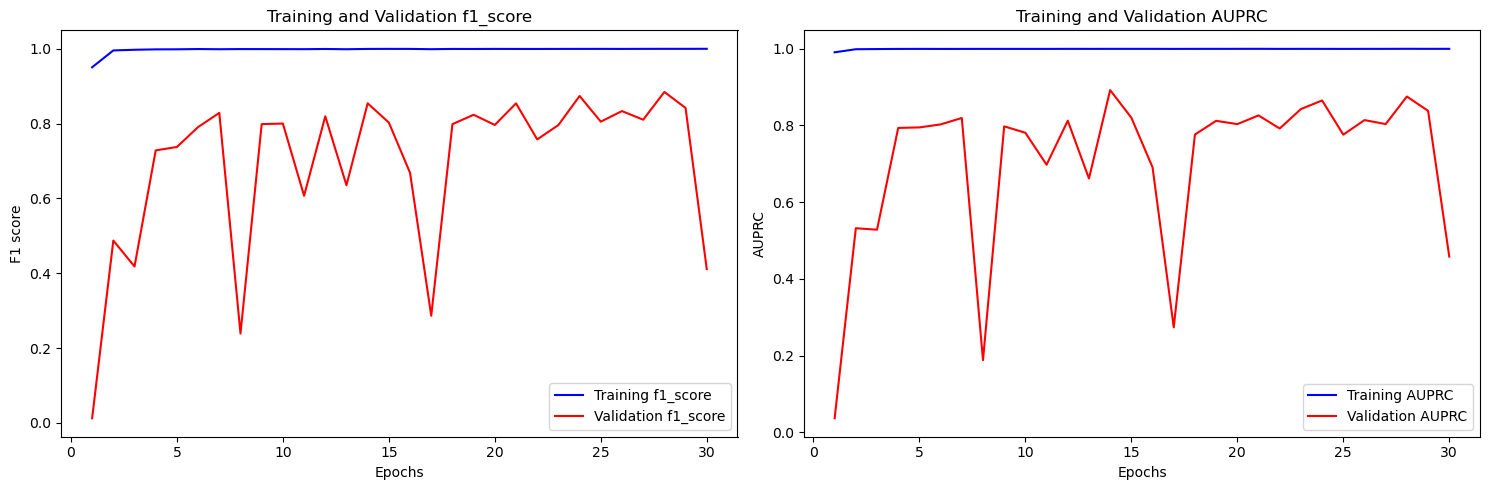

Best Validation F1 Score: 0.8845
Best Validation AUPRC: 0.8923


In [12]:
evaluate_model(history_teacher)

## Model for the Arduino Nano 33 BLE Sense Rev2

In [13]:
cnn_uncompressed = create_model_uncompressed()
cnn_uncompressed.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 250, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 250, 64, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 64, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 125, 32, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 32, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 32, 16)    │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 32, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 15, 4, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 4, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 113,585 (443.69 KB)

 Trainable params: 113,089 (441.75 KB)

 Non-trainable params: 496 (1.94 KB)

Epoch 1/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auprc: 0.7011 - f1_score: 0.6917 - loss: 0.6005
Epoch 1: val_f1_score improved from -inf to 0.05993, saving model to models/cnn_uncompressed.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - auprc: 0.7013 - f1_score: 0.6919 - loss: 0.6003 - val_auprc: 0.0746 - val_f1_score: 0.0599 - val_loss: 1.8673
Epoch 2/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auprc: 0.9500 - f1_score: 0.8910 - loss: 0.2661
Epoch 2: val_f1_score improved from 0.05993 to 0.12636, saving model to models/cnn_uncompressed.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - auprc: 0.9501 - f1_score: 0.8910 - loss: 0.2660 - val_auprc: 0.5312 - val_f1_score: 0.1264 - val_loss: 0.6386
Epoch 3/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auprc: 0.9811 - f1_score: 0.9333 - loss: 0.1586
Epoch 3: val_f1_score improved from 0.12636 to 0.14059, saving model to models/cnn_uncompressed.keras
441/441 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - auprc: 0.9811 - f1_score: 0.9333 

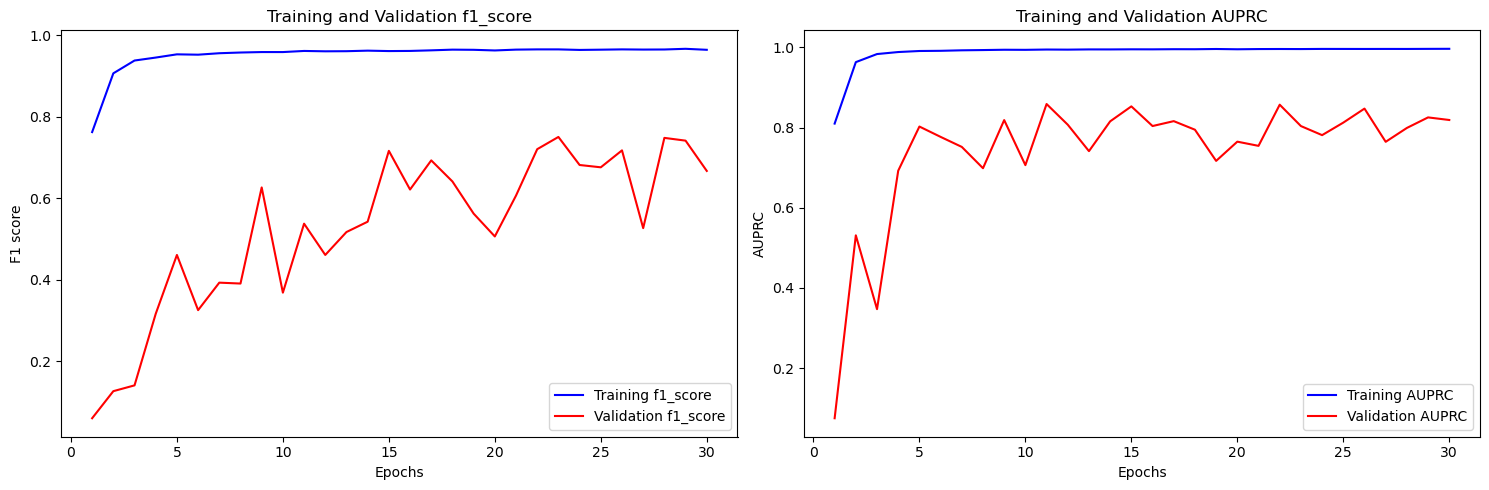

Best Validation F1 Score: 0.7500
Best Validation AUPRC: 0.8589


In [14]:
history_cnn_uncompressed = cnn_uncompressed.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[f1_checkpoint("cnn_uncompressed.keras")]
)
evaluate_model(history_cnn_uncompressed)

### Pruning our model

In [15]:
temp_cnn = tf.keras.models.load_model("models/cnn_uncompressed.keras")

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.2,
        begin_step=1000,
        end_step=6000,
        frequency=200
    )
}
# Pruning doesn't work well, so we remove it
# pruned_cnn = tfmot.sparsity.keras.prune_low_magnitude(temp_cnn, **pruning_params)
# pruned_cnn.compile(
#     optimizer="adam", 
#     loss="binary_crossentropy", 
#     metrics=[tf.keras.metrics.F1Score(average="micro", threshold=0.5, name="f1_score")]
# )
# callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

# pruned_cnn.fit(
#     train_dataset,
#     epochs=num_epochs,
#     validation_data=val_dataset,
#     callbacks=callbacks
# )

# cnn1 = tfmot.sparsity.keras.strip_pruning(pruned_cnn)
# cnn1.save("models/cnn.keras")
temp_cnn.save("models/cnn.keras")

### Distilling the knowledge of the teacher model

Epoch 1/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 165s 206ms/step - f1_score: 0.9985 - loss: 4.7213e-04 - val_f1_score: 0.7522 - val_loss: 0.0051
Epoch 2/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 65s 120ms/step - f1_score: 0.9997 - loss: 9.2219e-05 - val_f1_score: 0.8119 - val_loss: 0.0050
Epoch 3/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 65s 120ms/step - f1_score: 0.9983 - loss: 4.5073e-04 - val_f1_score: 0.8076 - val_loss: 0.0047
Epoch 4/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 65s 120ms/step - f1_score: 0.9998 - loss: 6.1519e-05 - val_f1_score: 0.8000 - val_loss: 0.0057
Epoch 5/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 65s 120ms/step - f1_score: 0.9998 - loss: 6.3527e-05 - val_f1_score: 0.8043 - val_loss: 0.0066
Epoch 6/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 65s 120ms/step - f1_score: 0.9999 - loss: 1.2518e-05 - val_f1_score: 0.7739 - val_loss: 0.0076
Epoch 7/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 65s 121ms/step - f1_score: 0.9999 - loss: 2.6792e-05 - val_f1_score: 0.8179 - val_loss: 0.0066
Epoch 8/30
441/441 ━━━━━━━━━━━━━━━━━━━━ 65s 120ms/step

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

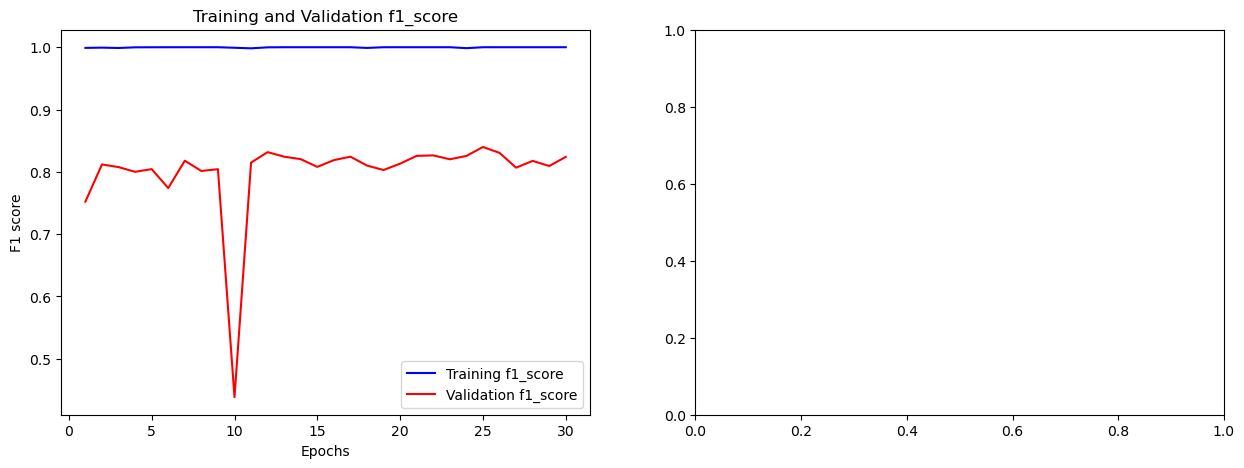

In [16]:
teacher = tf.keras.models.load_model("models/teacher.keras")
student = tf.keras.models.load_model("models/cnn.keras")

distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=[
        tf.keras.metrics.F1Score(average="micro", threshold=0.5, name="f1_score"),
        tf.keras.metrics.AUC(curve="PR", name="auprc"),
        ],
    student_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3,
)

history_distiller = distiller.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    
)

evaluate_model(history_distiller)
distiller.student.save("models/cnn_distilled.keras")

**The minor evaluation error in the code above was fixed post-training. It should not appear if you redistill the model.**

In [17]:
distiller.student.save("models/cnn_distilled.keras")

### Converting our models to TensorflowLite Model

In [20]:
cnn_to_convert = tf.keras.models.load_model("models/cnn_distilled.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_to_convert)
converter.optimizations = [tf.lite.Optimize.DEFAULT] 

tflite_cnn = converter.convert()

output_tflite = "models/cnn.tflite"
with open(output_tflite, "wb") as f:
    f.write(tflite_cnn)

INFO:tensorflow:Assets written to: /tmp/tmpszru9v8z/assets
Saved artifact at '/tmp/tmpszru9v8z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 64, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140162187979536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187983184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187982992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187978576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187977040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187982608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187982032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187984528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187984720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140162187706448: TensorSp

#### Checking our model fits within the requirements

To ensure that our TFLite models can indeed be run given our constraints, one can also use a public [python script](https://github.com/usefulsensors/calc_mem/tree/main) imported in our `utils` directory.

In [21]:
calc_mem(output_tflite)

OP_NAME            | In+Out memory used
------------------------------
CONV_2D            | 140.7 KBs
MUL                | 250.0 KBs
ADD                | 250.0 KBs
MAX_POOL_2D        | 156.2 KBs
CONV_2D            | 94.9 KBs
MUL                | 125.0 KBs
ADD                | 125.0 KBs
MAX_POOL_2D        | 78.0 KBs
CONV_2D            | 51.0 KBs
MUL                | 62.0 KBs
ADD                | 62.0 KBs
MAX_POOL_2D        | 38.8 KBs
CONV_2D            | 41.3 KBs
MUL                | 31.1 KBs
ADD                | 31.1 KBs
MAX_POOL_2D        | 19.2 KBs
CONV_2D            | 83.4 KBs
MUL                | 15.1 KBs
ADD                | 15.1 KBs
MAX_POOL_2D        | 9.2 KBs
RESHAPE            | 3.5 KBs
FULLY_CONNECTED    | 15.8 KBs
FULLY_CONNECTED    | 0.0 KBs
LOGISTIC           | 0.0 KBs
------------------------------
Largest memory usage: 250.0 KBs


In [22]:
calc_flops(output_tflite)

OP_NAME            | M FLOPS
------------------------------
CONV_2D            | 2.3
CONV_2D            | 9.2
CONV_2D            | 9.1
CONV_2D            | 9.1
CONV_2D            | 8.8
------------------------------
Total: 38.7 M FLOPS


## Converting our TFLite model to a header file 

In [23]:
output_h = output_tflite[:-7] + "_data.h"
!xxd -i $output_tflite > $output_h
print(f"Your file has been saved in {output_h}!")

Your file has been saved in models/cnn_data.h!
